In [9]:
import pandas as pd
import pickle
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold

In [10]:
df = pd.read_csv("./clean_credit_score_classification.csv")
df.info()

C:\Users\ngova\AppData\Local\Temp\ipykernel_1568\3578781784.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./clean_credit_score_classification.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        150000 non-null  int64  
 1   Customer_ID               150000 non-null  int64  
 2   Month                     150000 non-null  int64  
 3   Name                      150000 non-null  object 
 4   Age                       150000 non-null  float64
 5   SSN                       150000 non-null  float64
 6   Occupation                150000 non-null  object 
 7   Annual_Income             150000 non-null  float64
 8   Monthly_Inhand_Salary     150000 non-null  float64
 9   Num_Bank_Accounts         150000 non-null  float64
 10  Num_Credit_Card           150000 non-null  float64
 11  Interest_Rate             150000 non-null  float64
 12  Num_of_Loan               150000 non-null  float64
 13  Type_of_Loan              150000 non-null  o

In [11]:
df.drop(['ID', 'Customer_ID', 'Name', 'SSN'], axis=1, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(df.drop('Credit_Score', axis=1).columns,inplace=True)

In [12]:
df['Occupation'] = df['Occupation'].astype('category').cat.codes
df['Credit_Mix'] = df['Credit_Mix'].astype('category').cat.codes
df['Payment_Behaviour'] = df['Payment_Behaviour'].astype('category').cat.codes
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].astype('category').cat.codes
labels = ["Poor", "Standard", "Good"]
df['Credit_Score'] = df['Credit_Score'].map(labels.index)

In [13]:
df['Type_of_Loan'] = df['Type_of_Loan'].str.replace(', and', ',')
loans_set = list(set([y for x in df['Type_of_Loan'] for y in x.split(', ')]))
df['Type_of_Loan'] = df['Type_of_Loan'].map(lambda line: np.array([True if x in line.split(', ') else False for x in loans_set]))
for item in loans_set:
    df[item] = df['Type_of_Loan'].map(lambda x: x[loans_set.index(item)])
df.drop(['Type_of_Loan'], axis=1, inplace=True)

In [14]:
def kfold_accurate(df: DataFrame, dfeatures: list):
    X = df.drop(dfeatures + ['Credit_Score'], axis=1)
    y = df['Credit_Score']
    X = np.array(X)
    y = np.array(y)
    accurate = []
    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=36)
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        clf = DecisionTreeClassifier(criterion='gini', class_weight=None, random_state=36)
        clf = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accurate.append(metrics.accuracy_score(y_test, y_pred))

    return np.mean(accurate)

In [15]:
kfold_accurate(df, [])

0.73469

In [16]:
kfold_accurate(df, loans_set)

0.73053

<AxesSubplot:xlabel='Month'>

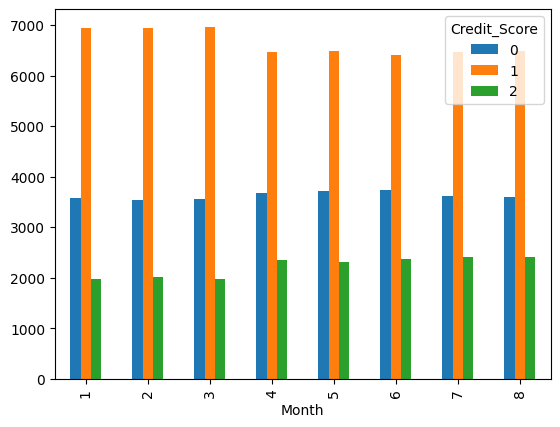

In [17]:
pd.crosstab(df['Month'], df['Credit_Score']).plot.bar()

In [18]:
kfold_accurate(df, ['Month'] + loans_set)

0.7329300000000001

In [19]:
dfeatures = []
i = 0
while True:
    i += 1
    print(f'Pruning feature: {i}')
    best = kfold_accurate(df, dfeatures + loans_set)
    best_dfeature = False
    for c in df.drop(dfeatures + loans_set + ['Credit_Score'], axis=1).columns:
        value = kfold_accurate(df, dfeatures + loans_set + [c])
        if value >= best:
            best = value
            best_dfeature = c
    if not best_dfeature:
        break
    dfeatures += [best_dfeature]
print(dfeatures)

Pruning feature: 1
Pruning feature: 2
Pruning feature: 3
Pruning feature: 4
Pruning feature: 5
Pruning feature: 6
Pruning feature: 7
Pruning feature: 8
Pruning feature: 9
Pruning feature: 10
Pruning feature: 11
Pruning feature: 12
Pruning feature: 13
Pruning feature: 14
['Credit_Utilization_Ratio', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Changed_Credit_Limit', 'Num_of_Delayed_Payment', 'Delay_from_due_date', 'Payment_of_Min_Amount', 'Num_Credit_Inquiries', 'Month', 'Monthly_Inhand_Salary', 'Age', 'Total_EMI_per_month']


In [20]:
kfold_accurate(df, dfeatures + loans_set)

0.81656

In [21]:
X = df.drop(dfeatures + loans_set + ['Credit_Score'], axis=1)
y = df['Credit_Score']
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=36)

clf = DecisionTreeClassifier(criterion='gini', class_weight=None)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), 
             index=['True ' + x for x in labels], 
             columns=['Predict ' + x for x in labels]))
print(metrics.classification_report(y_test, y_pred, target_names=labels))

               Predict Poor  Predict Standard  Predict Good
True Poor              5830              1415             4
True Standard          1367             11038           889
True Good                16               999          3442
              precision    recall  f1-score   support

        Poor       0.81      0.80      0.81      7249
    Standard       0.82      0.83      0.83     13294
        Good       0.79      0.77      0.78      4457

    accuracy                           0.81     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.81      0.81     25000



In [22]:
unique, counts = np.unique(y, return_counts=True)
y_dict = dict(zip(unique, counts))
class_weight = {0: 1 - y_dict[0]/len(y), 1: 1 - y_dict[1]/len(y), 2: 1 - y_dict[2]/len(y)}

In [23]:
important_features = {}
for name, value in zip(df.drop(dfeatures + loans_set + ['Credit_Score'], axis=1).columns, clf.feature_importances_):
  important_features[name] = value
important_features = dict(sorted(important_features.items(), key=lambda x: x[1]))
important_features

{'Num_of_Loan': 0.026756450294466987,
 'Num_Bank_Accounts': 0.034439464844785765,
 'Num_Credit_Card': 0.03757457382644687,
 'Occupation': 0.04487896106243672,
 'Interest_Rate': 0.06933086614420862,
 'Annual_Income': 0.0853910308668293,
 'Credit_Mix': 0.13447127844037507,
 'Outstanding_Debt': 0.21242889965534767,
 'Credit_History_Age': 0.354728474865103}

In [24]:
print(class_weight)

{0: 0.71002, 1: 0.46826, 2: 0.82172}


In [25]:
decision_tree = DecisionTreeClassifier(random_state=36)
params = {
    'max_depth': [None] + list(range(25, 60, 5)),
    'class_weight': [None, 'balanced', class_weight]
}
grid = GridSearchCV(decision_tree, params, cv=4, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'class_weight': None, 'max_depth': None}


In [27]:
X = df.drop(dfeatures + loans_set + ['Credit_Score'], axis=1)
y = df['Credit_Score']
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=36)

clf = DecisionTreeClassifier(**grid.best_params_, random_state=36)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), 
             index=['True ' + x for x in labels], 
             columns=['Predict ' + x for x in labels]))
print(metrics.classification_report(y_test, y_pred, target_names=labels))
print(metrics.accuracy_score(y_test, y_pred))

               Predict Poor  Predict Standard  Predict Good
True Poor              5837              1409             3
True Standard          1365             11035           894
True Good                16               996          3445
              precision    recall  f1-score   support

        Poor       0.81      0.81      0.81      7249
    Standard       0.82      0.83      0.83     13294
        Good       0.79      0.77      0.78      4457

    accuracy                           0.81     25000
   macro avg       0.81      0.80      0.81     25000
weighted avg       0.81      0.81      0.81     25000

0.81268


In [28]:
X = df.drop(dfeatures + loans_set + ['Credit_Score'], axis=1)
y = df['Credit_Score']
X = np.array(X)
y = np.array(y)

clf = DecisionTreeClassifier(**grid.best_params_)
clf = clf.fit(X, y)

clf.features = df.drop(dfeatures + loans_set + ['Credit_Score'], axis=1).columns
clf.labels = labels
with open('model.pkl', 'wb') as file:
    pickle.dump(clf, file)